In [ ]:
!pip install pyradiomics


In [ ]:
# Install necessary packages
!pip install numpy
!pip install SimpleITK
!pip install pandas
!pip install openpyxl
!pip install nibabel
#!pip install pyradiomics

In [ ]:
# Directory containing the NIfTI files
input_dir = 'C:/Users/17753/Downloads/Features/T2W/T2masks/'


In [2]:
# Import necessary libraries
import os


import SimpleITK as sitk
import six

from radiomics import featureextractor, getTestCase

import numpy as np
import pandas as pd
import nibabel as nib

In [ ]:
def extract_radiomics_features(image_path, mask_path):
    # Initialize the feature extractor
    extractor = featureextractor.RadiomicsFeatureExtractor()

    # Read image and mask
    image = sitk.ReadImage(image_path)
    mask = sitk.ReadImage(mask_path)

    # Ensure mask and image have the same origin, spacing, and direction
    mask.SetOrigin(image.GetOrigin())
    mask.SetSpacing(image.GetSpacing())
    mask.SetDirection(image.GetDirection())

    # Extract features
    feature_vector = extractor.execute(image, mask)

    return feature_vector


In [ ]:
#input_dir = 'path_to_your_input_directory'  # Replace with your actual input directory
output_file = 'C:/Users/17753/Downloads/Features/T2W/T2mask_radiomics_features.xlsx'  # Output Excel file name

results = []

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.nii.gz'):
            image_path = os.path.join(root, file)
            mask_path = image_path  # Assuming masks are in the same directory
            features = extract_radiomics_features(image_path, mask_path)

            # Convert features to a dictionary and add the filename
            feature_dict = dict(features)
            feature_dict['filename'] = file
            results.append(feature_dict)

# Save results to Excel
import pandas as pd

df = pd.DataFrame(results)
df.to_excel(output_file, index=False)


In [ ]:
#lasso regression to automate feature selection

In [3]:
# Load the libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Read the Excel file
t2w_features = pd.read_excel('C:/Users/17753/Downloads/Features/T2W/T2mask_output.xlsx')
t2w_features = pd.DataFrame(t2w_features)
# Display the first few rows of the dataframe to ensure it's loaded correctly
#print(t2w_features.head(3))
#print(df_features.columns)
print(t2w_features.shape)


In [ ]:
#print(t2w_features.isnull().sum())

In [ ]:
###Automatic selection of features using LASSO

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

def perform_lasso_feature_selection(df_features, target_column, exclude_columns):
    # Extract relevant feature columns (excluding the target and any other specified columns)
    feature_cols = df_features.columns.difference([target_column] + exclude_columns)
    features = df_features[feature_cols].values

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Extract the target variable
    target_variable = df_features[target_column].values

    # Apply Lasso regression for feature selection
    lasso = Lasso(alpha=1, max_iter=100000)  # Adjust alpha parameter as needed
    lasso.fit(features_scaled, target_variable)

    # Retrieve selected features based on non-zero coefficients
    selected_features = feature_cols[lasso.coef_ != 0]

    return selected_features


In [ ]:
# Perform Lasso feature selection Automatic meathod
selected_t2wfeatures = perform_lasso_feature_selection(t2w_features, target_column='original_firstorder_TotalEnergy', exclude_columns=['filename'])
print("Selected features:", selected_t2wfeatures)

In [19]:
###This the method we are using for selecting importance method for feature extraction
#https://medium.com/@agrawalsam1997/feature-selection-using-lasso-regression-10f49c973f08
# Segregating the Feature and Target
t2w_features_no_filename = t2w_features.drop(columns=['filename'])
X = t2w_features_no_filename.drop("original_firstorder_TotalEnergy", axis=1).values
y = t2w_features_no_filename["original_firstorder_TotalEnergy"].values


In [20]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2)#stratify=y

print("T2W of Train Features: {}".format(X_train.shape))
print("T2W of Test Features: {}".format(X_test.shape))
print("T2W of Train Target: {}".format(y_train.shape))
print("T2W of Test Target: {}".format(y_test.shape))

T2W of Train Features: (109, 43)
T2W of Test Features: (28, 43)
T2W of Train Target: (109,)
T2W of Test Target: (28,)


In [21]:
####This is just for test
from sklearn.model_selection import KFold
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(1, 10, 100)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=2)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1}


In [60]:
#This is what we are using: Negelect just above Best params
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter grid using np.logspace to cover a wide range of alpha values
params = {"alpha": np.logspace(-5, 1, 10)}

# Number of Folds and adding the random state for replication
kf = KFold(n_splits=5, shuffle=True, random_state=2)

# Initializing the Model
lasso = Lasso(max_iter=100000)  # Increase the number of iterations

# GridSearchCV with model, params, and folds
lasso_cv = GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_scaled, y)

# Print the best parameter found by GridSearchCV
print("Best Params: {}".format(lasso_cv.best_params_))

Best Params: {'alpha': 0.1}


In [22]:
names=t2w_features_no_filename.drop("original_firstorder_TotalEnergy", axis=1).columns
#print("Column Names: {}".format(names.values))

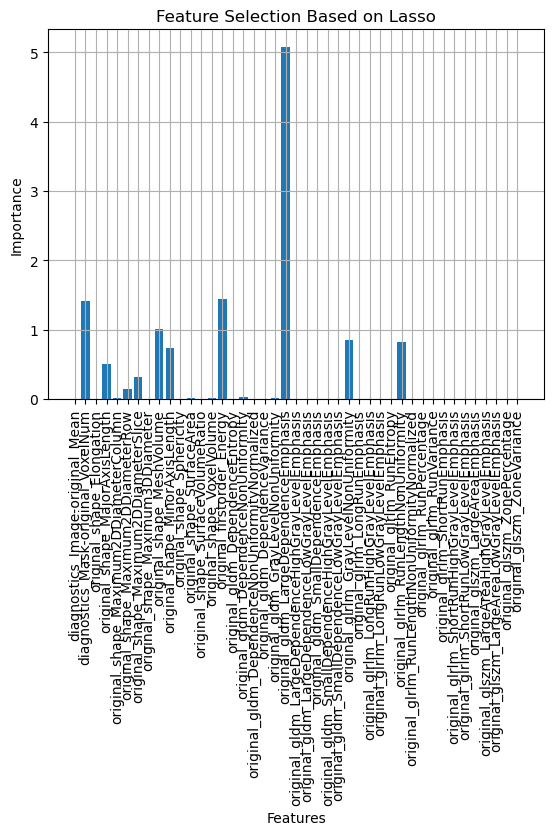

In [23]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.1)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0,)
plt.show()

In [24]:
# Subsetting the features which has more than 0.1 importance.
feature_subset=np.array(names)[lasso1_coef>0.1]
print("Selected Feature Columns: {}".format(feature_subset))

# Adding the target to the list of feaatures. 
feature_subset=np.append(feature_subset, "original_firstorder_TotalEnergy")
print("Selected Columns: {}".format(feature_subset))

Selected Feature Columns: ['diagnostics_Mask-original_VoxelNum' 'original_shape_MajorAxisLength'
 'original_shape_Maximum2DDiameterRow'
 'original_shape_Maximum2DDiameterSlice' 'original_shape_MeshVolume'
 'original_shape_MinorAxisLength' 'original_firstorder_Energy'
 'original_gldm_LargeDependenceEmphasis'
 'original_glrlm_GrayLevelNonUniformity'
 'original_glrlm_RunLengthNonUniformity']
Selected Columns: ['diagnostics_Mask-original_VoxelNum' 'original_shape_MajorAxisLength'
 'original_shape_Maximum2DDiameterRow'
 'original_shape_Maximum2DDiameterSlice' 'original_shape_MeshVolume'
 'original_shape_MinorAxisLength' 'original_firstorder_Energy'
 'original_gldm_LargeDependenceEmphasis'
 'original_glrlm_GrayLevelNonUniformity'
 'original_glrlm_RunLengthNonUniformity' 'original_firstorder_TotalEnergy']


In [25]:
t2w_important = t2w_features_no_filename[feature_subset]
#print(t2w_important.head(2))

In [26]:
#save file in excel
t2w_important.to_excel('C:/Users/17753/Downloads/Features/T2W/t2w_important_features.xlsx', index=False)

In [49]:
# Filter out coefficients smaller than 1e-6

threshold = 1e-6
non_zero_indices = np.where(np.abs(lasso1_coef) >= threshold)[0]
filtered_coefficients = lasso1_coef[non_zero_indices]
filtered_feature_names = np.array(names)[non_zero_indices]

# Create a DataFrame with filtered coefficients and corresponding feature names
T2W_selected = pd.DataFrame({
    'Feature': filtered_feature_names,
    'Coefficient': filtered_coefficients
})

# Print the intercept
print("Intercept:", lasso1.intercept_)

# Print the filtered coefficients
print(T2W_selected)

Intercept: 375.83858410326684
                                   Feature  Coefficient
0       diagnostics_Mask-original_VoxelNum     1.416827
1           original_shape_MajorAxisLength     0.509382
2   original_shape_Maximum2DDiameterColumn     0.012614
3      original_shape_Maximum2DDiameterRow     0.140060
4    original_shape_Maximum2DDiameterSlice     0.311574
5                original_shape_MeshVolume     1.006486
6           original_shape_MinorAxisLength     0.733728
7               original_shape_SurfaceArea     0.017992
8               original_shape_VoxelVolume     0.020621
9               original_firstorder_Energy     1.448463
10   original_gldm_DependenceNonUniformity     0.024235
11    original_gldm_GrayLevelNonUniformity     0.021549
12   original_gldm_LargeDependenceEmphasis     5.073385
13   original_glrlm_GrayLevelNonUniformity     0.851872
14          original_glrlm_LongRunEmphasis     0.004460
15   original_glrlm_RunLengthNonUniformity     0.820200
16              or

In [50]:
# Add the intercept to the DataFrame
df_intercept = pd.DataFrame({
    'Feature': ['Intercept'],
    'Coefficient': lasso1.intercept_
})
print(df_intercept)

     Feature  Coefficient
0  Intercept   375.838584


In [51]:
T2W_final = pd.concat([T2W_selected, df_intercept])
print(T2W_final)

                                   Feature  Coefficient
0       diagnostics_Mask-original_VoxelNum     1.416827
1           original_shape_MajorAxisLength     0.509382
2   original_shape_Maximum2DDiameterColumn     0.012614
3      original_shape_Maximum2DDiameterRow     0.140060
4    original_shape_Maximum2DDiameterSlice     0.311574
5                original_shape_MeshVolume     1.006486
6           original_shape_MinorAxisLength     0.733728
7               original_shape_SurfaceArea     0.017992
8               original_shape_VoxelVolume     0.020621
9               original_firstorder_Energy     1.448463
10   original_gldm_DependenceNonUniformity     0.024235
11    original_gldm_GrayLevelNonUniformity     0.021549
12   original_gldm_LargeDependenceEmphasis     5.073385
13   original_glrlm_GrayLevelNonUniformity     0.851872
14          original_glrlm_LongRunEmphasis     0.004460
15   original_glrlm_RunLengthNonUniformity     0.820200
16              original_glrlm_RunVariance     0

In [52]:
T2W_final.to_excel('C:/Users/17753/Downloads/Features/T2W/t2w_non_zero_coeffs.xlsx', index=False)